# Regression / GPUs Dataset Analysis
***

***Piotr Skalski - 13.10.2017***

<b>Note:</b> The growth of computer games market has resulted in great development of Graphic Cards. In this Kernel I will use <a href="https://www.kaggle.com/iliassekkaf/computerparts">Computer Parts Dataset</a> and regression models to predict how powerfull will Graphics Cards be in 2025. I will focuse on most important parameters of GPUs like:

* <b>Core Speed [MHz]</b> - The frequency at which the GPU is running. This can be sort of compared to a CPU's operating frequency. "Speed" depends on numerous factors, architecture being one of them. It's not necessarily an apples-to-apples comparison to look at the core clock speed of an older GPU and a newer one (or cross-brand differences), but for sake of ease, greater core frequencies equates faster computing. Be careful with that, though, calculating speed in gaming is never quite so linear.

* <b>Memory Bandwidth [GB/sec]</b> - This is one of the single, most important aspects of graphics processors. Memory bandwidth determines your card's ability to utilize its onboard video RAM efficiently when under stress.

* <b>Memory Size [MB or GB]</b> - VRAM is the storage location for textures and 3D meshes. So the more available, the more complex the scene can be, before it overflows to the standard RAM.

---

More informations on GPUs parameters: <a href="https://www.gamersnexus.net/guides/717-gpu-dictionary-understanding-gpu-video-card-specs">GPU Dictionary: Understanding GPU & Video Card Specs</a>

---

### Moore's law: Number of transistors in a dense integrated circuit doubles approximately every two years. 

<img src='https://upload.wikimedia.org/wikipedia/commons/f/fe/GeForce4_Ti_4800SE_NV28_GPU.jpg'>

# Table of Contents

* [1. Importing dataset and data preprocessing](#importing_dataset_and_data_preprocessing) <br>
   * [1.1. Dataset import](#dataset_import) <br>
   * [1.2. Let's summarize the Dataset](#lets_summarize_the_dataset) <br>
   * [1.3. Data preprocessing & feature engineering](#data_preprocessing) <br>
<br>
* [2. Basic data visualization](#basic_data_visualization) <br>
   * [2.1. Grouping GPUs by Release Year](#grouping_gpus_by_release_year) <br>
   * [2.2. GPU Memory vs Year of Release by Manufacturer](#gpu_memory_vs_year_of_release_by_manufacturer) <br>
   * [2.3. GPU manufacturers market share](#gpu_manufacturers_market_share) <br>
<br>
* [3. GPU Memory](#gpu_memory) <br>
    * [3.1. GPU Memory vs Year of Release (Scatter Plot)](#gpu_memory_vs_year_of_release) <br>
    * [3.2. Mean GPU Memory vs Year of Release (Line Plot)](#mean_gpu_memory_vs_year_of_release) <br>
    * [3.3. Creating theoretic model and fitting exponential curve](#polynomial_regression_prediction_model) <br>
    * [3.4. Polynomial regression prediction model](#creating_theoretic_model_and_fitting_exponential_curve) <br>
    * [3.5. Selecting best model](#selecting_best_model) <br>
    * [3.6. Predicting GPUs mean memory size in 2025](#predicting_gpus_mean_memory_size_in_2025) <br>
<br>
* [4. Bibliography](#bibliography) <br>

## 1. Importing dataset and data preprocessing
<a id="importing_dataset_and_data_preprocessing"></a>

### 1.1. Dataset import
<a id="dataset_import"></a>

In [4]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

In [43]:
# Let's import dataset from csv file
dataset = pd.read_csv('data/All_GPUs.csv')

### 1.2. Let's try to summarize the Dataset
<a id="lets_summarize_the_dataset"></a>

In [44]:
dataset.head(10)

,Architecture,Best_Resolution,Boost_Clock,Core_Speed,DVI_Connection,Dedicated,Direct_X,DisplayPort_Connection,HDMI_Connection,Integrated,...,Process,ROPs,Release_Date,Release_Price,Resolution_WxH,SLI_Crossfire,Shader,TMUs,Texture_Rate,VGA_Connection
0,Tesla G92b,NaN,NaN,738 MHz,2.0,Yes,DX 10.0,NaN,0.0,No,...,55nm,16,\n01-Mar-2009,NaN,2560x1600,Yes,4.0,64.0,47 GTexel/s,0.0
1,R600 XT,1366 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,16,\n14-May-2007,NaN,2560x1600,Yes,4.0,16.0,12 GTexel/s,0.0
2,R600 PRO,1366 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,16,\n07-Dec-2007,NaN,2560x1600,Yes,4.0,16.0,10 GTexel/s,0.0
3,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n01-Jul-2007,NaN,2560x1600,Yes,4.0,8.0,7 GTexel/s,0.0
4,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n28-Jun-2007,NaN,2560x1600,Yes,4.0,8.0,6 GTexel/s,0.0
5,RV630,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,65nm,4,\n26-Jun-2007,NaN,2560x1600,Yes,4.0,8.0,6 GTexel/s,0.0
6,R700 RV790 XT,1920 x 1080,NaN,870 MHz,1.0,Yes,DX 10.1,NaN,1.0,No,...,55nm,16,\n13-Jul-2009,NaN,2560x1600,Yes,4.1,40.0,35 GTexel/s,1.0
7,R600 GT,1024 x 768,NaN,\n-,2.0,Yes,DX 10,NaN,0.0,No,...,80nm,12,\n06-Nov-2007,NaN,2560x1600,Yes,4.0,12.0,7 GTexel/s,0.0
8,Pitcairn XT GL,1920 x 1080,NaN,\n-,0.0,Yes,DX 11.2,NaN,0.0,No,...,28nm,32,\n18-Jan-2014,NaN,4096x2160,Yes,5.0,80.0,62 GTexel/s,0.0
9,RV100,NaN,NaN,\n-,NaN,Yes,DX 7,NaN,NaN,No,...,NaN,NaN,\n02-Jan-2001,NaN,1600x1200,No,1.0,NaN,NaN,NaN


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3406 entries, 0 to 3405
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Architecture            3344 non-null   object 
 1   Best_Resolution         2764 non-null   object 
 2   Boost_Clock             1446 non-null   object 
 3   Core_Speed              3406 non-null   object 
 4   DVI_Connection          2656 non-null   float64
 5   Dedicated               3392 non-null   object 
 6   Direct_X                3400 non-null   object 
 7   DisplayPort_Connection  857 non-null    float64
 8   HDMI_Connection         2643 non-null   float64
 9   Integrated              3392 non-null   object 
 10  L2_Cache                3406 non-null   object 
 11  Manufacturer            3406 non-null   object 
 12  Max_Power               2781 non-null   object 
 13  Memory                  2986 non-null   object 
 14  Memory_Bandwidth        3285 non-null   

<b> NOTE: </b> Right away we can see that there is lots of undefined values. Let's use "Missingno" package which is a most useful and convenient tool in visualising missing values in the dataset. There are only few columns that can by use as reliable source of information for our analysis. Most of columns are incomplete or in wrong format. We will perform data preprocessing to make some columns usefull in our analysis.

<AxesSubplot:>

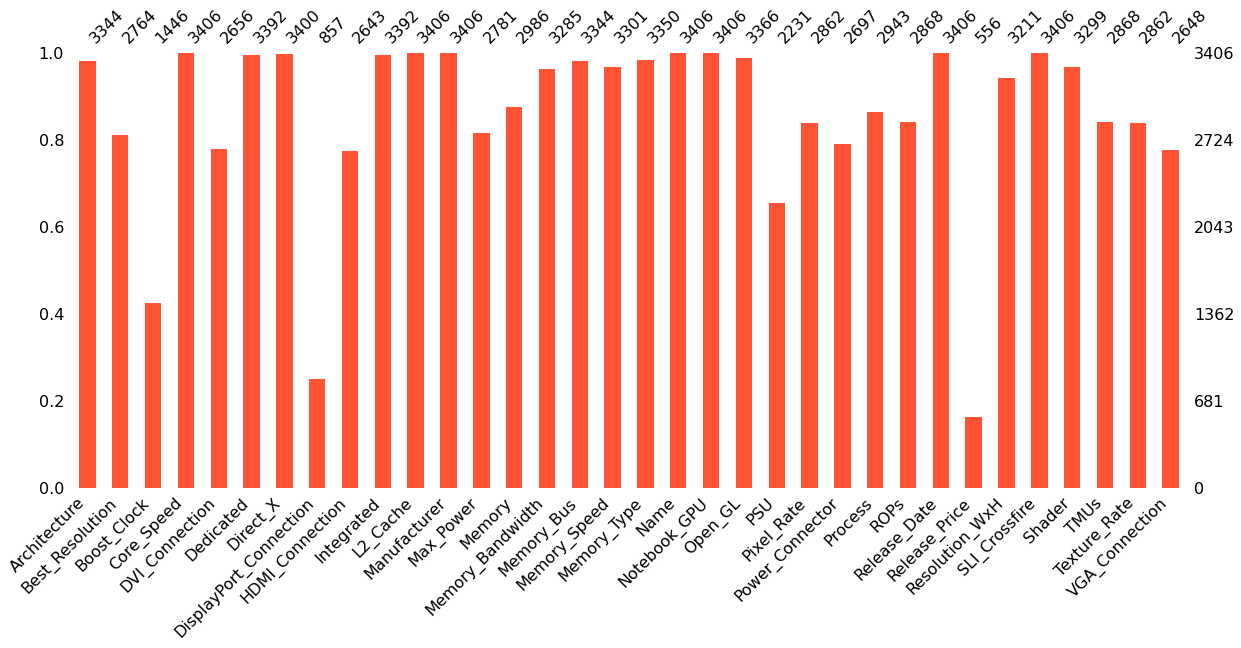

In [10]:
import missingno as msno

# Nullity or missing values by columns
#msno.matrix(df=dataset, figsize=(20, 8), color=(255/255, 83/255, 51/255))

msno.bar(df=dataset, figsize=(20, 8), color=(255/255, 83/255, 51/255))

<b>NOTE: </b> Basing on the conducted research we will select columns that represents key data for our project.

In [13]:
key_columns = ['Best_Resolution', 'Core_Speed', 'Manufacturer', 'Memory', 'Memory_Bandwidth', 'Name', 'Release_Date']
dataset = dataset[key_columns]

In [46]:
dataset["Memory"].head()

0    1024 MB 
1     512 MB 
2     512 MB 
3     256 MB 
4     256 MB 
Name: Memory, dtype: object

### 1.3. Data preprocessing & feature engineering
<a id="data_preprocessing"></a>

In [14]:
dataset['Release_Date']=dataset['Release_Date'].str[1:-1]
dataset=dataset[dataset['Release_Date'].str.len()==11]
dataset['Release_Date']= \
    pd.to_datetime(dataset['Release_Date'], format='%d-%b-%Y')
dataset['Release_Year']=dataset['Release_Date'].dt.year
dataset['Release_Month']=dataset['Release_Date'].dt.month
dataset['Release']= \
    dataset['Release_Year'] + dataset['Release_Month']/12

In [40]:
dataset.head()

,Best_Resolution,Core_Speed,Manufacturer,Memory,Memory_Bandwidth,Name,Release_Date,Release_Year,Release_Month,Release,PixelNum
0,NaN,738 MHz,Nvidia,1024,64GB/sec,GeForce GTS 150,2009-03-01,2009,3,2009.250000,480000
1,1366 x 768,\n-,AMD,512,106GB/sec,Radeon HD 2900 XT 512MB,2007-05-14,2007,5,2007.416667,1049088
2,1366 x 768,\n-,AMD,512,51.2GB/sec,Radeon HD 2900 Pro,2007-12-07,2007,12,2008.000000,1049088
3,1024 x 768,\n-,AMD,256,36.8GB/sec,Radeon HD 2600 XT Diamond Edition,2007-07-01,2007,7,2007.583333,786432
4,1024 x 768,\n-,AMD,256,22.4GB/sec,Radeon HD 2600 XT,2007-06-28,2007,6,2007.500000,786432


In [15]:
dataset['Memory'] = dataset['Memory'].str[:-3].fillna(0).astype(int)

In [16]:
def countPixels(x):
    if pd.isnull(x):
        return 800*600;
    else:
        values = x.split(' x ')
        return(int(values[0]) * int(values[1]))

dataset['PixelNum'] = dataset['Best_Resolution'] \
    .apply(lambda x: countPixels(x))

## 2. Basic data visualization
<a id="basic_data_visualization"></a>

### 2.1. Grouping GPUs by Release Year
<a id="grouping_gpus_by_release_year"></a>

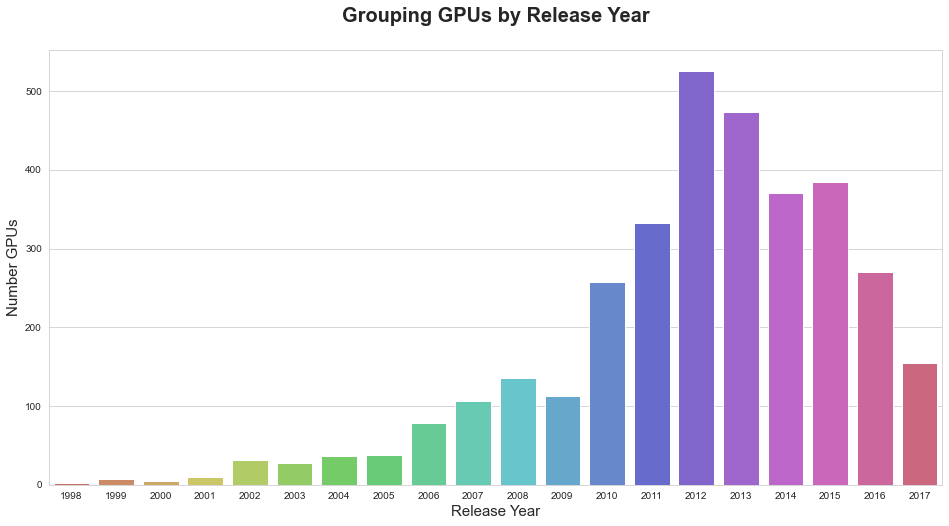

In [23]:
plt.figure(figsize=(16,8))
sns.set_style("whitegrid")
sns.countplot(x="Release_Year", data=dataset, palette="hls");
plt.title('Grouping GPUs by Release Year', fontsize=20, fontweight='bold', y=1.05,)
plt.ylabel('Number GPUs', fontsize=15)
plt.xlabel('Release Year', fontsize=15)
plt.show()

### 2.2. GPU Memory vs Year of Release by Manufacturer
<a id="gpu_memory_vs_year_of_release_by_manufacturer"></a>

In [24]:
data = []

for manufacturer in dataset['Manufacturer'].unique():
    
    trace_dataset = dataset.loc[dataset['Manufacturer'] == manufacturer]
    
    trace = go.Scatter(
        x = trace_dataset['Release_Year'],
        y = trace_dataset['Memory'],
        mode = 'markers',
        name = manufacturer,
        marker= dict(symbol="circle",
                    size = trace_dataset['PixelNum']/100000,
                    opacity = 0.4,
                    line= dict(width=1,
                               color = 'rgb(255, 255, 255)'
                              ),
        ),
        text= dataset['Name']
    )
    
    data.append(trace)
    
layout = dict(title = 'GPU Memory vs Year of Release by Manufacturer',
              width=1000,
              height=800,
              paper_bgcolor='rgb(243, 243, 243)',
              plot_bgcolor='rgb(243, 243, 243)',
              yaxis = dict(title= 'GPUs Memory',
                           ticklen= 5,
                           gridcolor='rgb(255, 255, 255)',
                           gridwidth= 2),
              xaxis = dict(title= 'Year of Release',
                           ticklen= 5,
                           gridcolor='rgb(255, 255, 255)',
                           gridwidth= 2)
             )

fig= go.Figure(data=data, layout=layout)
py.iplot(fig)

<b>NOTE:</b> Circle size represents maximum resolution that is supported by GPU.

### 2.3. GPU manufacturers market share
<a id="gpu_manufacturers_market_share"></a>

In [25]:
# Transformed dataset - counting 
#   how many GPUs were made by each manufacturer each year

market_share = dataset.reset_index() \
    .groupby(['Release_Year','Manufacturer'])["index"] \
    .count().reset_index(name="count")

# Transformed dataset - counting how many GPUs were made each year

market_share['Sum_By_Year']  = market_share['count'] \
    .groupby(market_share["Release_Year"]).transform('sum')


# List that will hold our data dictionaries

data = []

markers = [
    dict(
        color='rgba(55, 128, 191, 0.7)',
        line=dict(
            color='rgba(55, 128, 191, 1.0)',
            width=2,
        )
    ),
    dict(
        color='rgba(219, 64, 82, 0.7)',
        line=dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2,
        )
    ),
    dict(
        color='rgba(0, 168, 107, 0.7)',
        line=dict(
            color='rgba(0, 168, 107, 1.0)',
            width=2,
        )
    ),
    dict(
        color='rgba(250, 92, 0, 0.7)',
        line=dict(
            color='rgba(250, 92, 0, 1.0)',
            width=2,
        )
    )
]

for i, manufacturer in enumerate(dataset['Manufacturer'].unique()):
    
    trace_dataset = market_share \
        .loc[market_share['Manufacturer'] == manufacturer]
        
    trace = go.Bar(
        x = trace_dataset['Release_Year'],
        y = round(trace_dataset['count'] / trace_dataset['Sum_By_Year'] * 100, 2),
        name= manufacturer,
        marker = markers[i],
    )
    
    data.append(trace)
    
layout = go.Layout(
    barmode='stack',
    title = 'GPU manufacturers market share',
    width=1000,
    height=500,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title= 'Manufacturers market share [%]'),
    xaxis = dict(title= 'Manufacturers')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

<b>NOTE:</b> It is very likely that dataset for years 2016/2017 is incomplete.

## 3. GPU Memory
<a id="gpu_memory"></a>

### 3.1. GPU Memory vs Year of Release (Scatter Plot)
<a id="gpu_memory_vs_year_of_release"></a>

<b>NOTE:</b> Firstly, lets prepere simple scatter plot and look at relation between year of release and memory size of GPU.

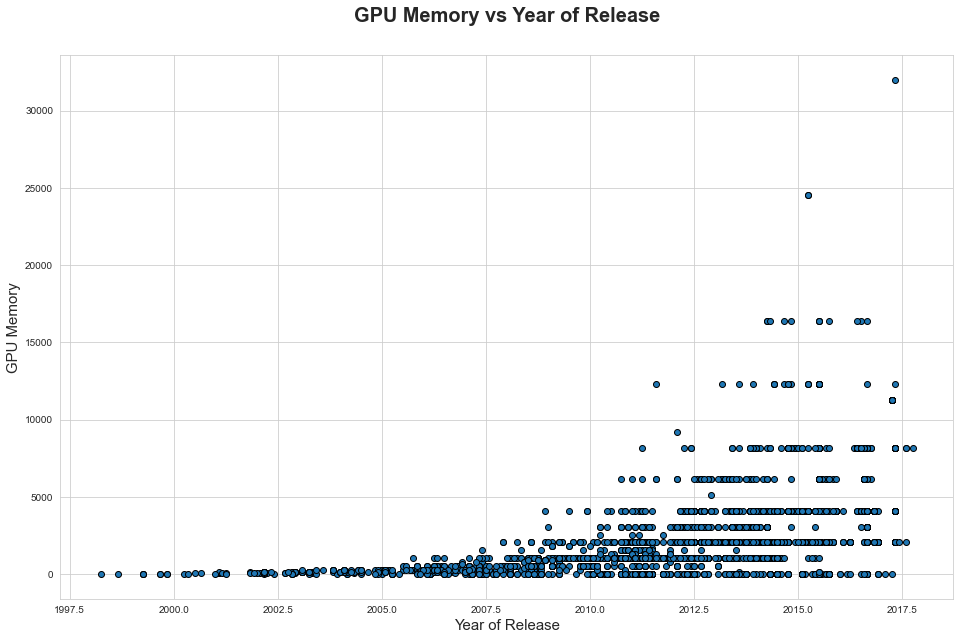

In [27]:
plt.figure(figsize=(16,10))
sns.set_style("whitegrid")
plt.title('GPU Memory vs Year of Release', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Year of Release', fontsize=15)
plt.ylabel('GPU Memory', fontsize=15)

years = dataset["Release"].values
memory = dataset["Memory"].values

plt.scatter(years, memory, edgecolors='black')
plt.show()

### 3.2. Mean GPU Memory vs Year of Release (Line Plot)
<a id="mean_gpu_memory_vs_year_of_release"></a>

<b>NOTE:</b> Now we will calculate mean and median Memory Size of GPU for each year and create line plots to visualize the upward trend. Right away we see that Moore's law quite accurate.

In [28]:
# Numpy array that holds unique release year values

year_arr = dataset.sort_values("Release_Year")['Release_Year'].unique()

# Numpy array that holds mean values of GPUs memory for each year

memory_arr_mean = dataset.groupby('Release_Year')['Memory'].mean().values

# Numpy array that holds median values of GPUs memory for each year

memory_arr_median = dataset.groupby('Release_Year')['Memory'].median().values


# Minimal value of release year from dataset

year_min = year_arr[0]

# Median size of memory in year_min

memory_min = memory_arr_median[0]

<Figure size 432x288 with 0 Axes>

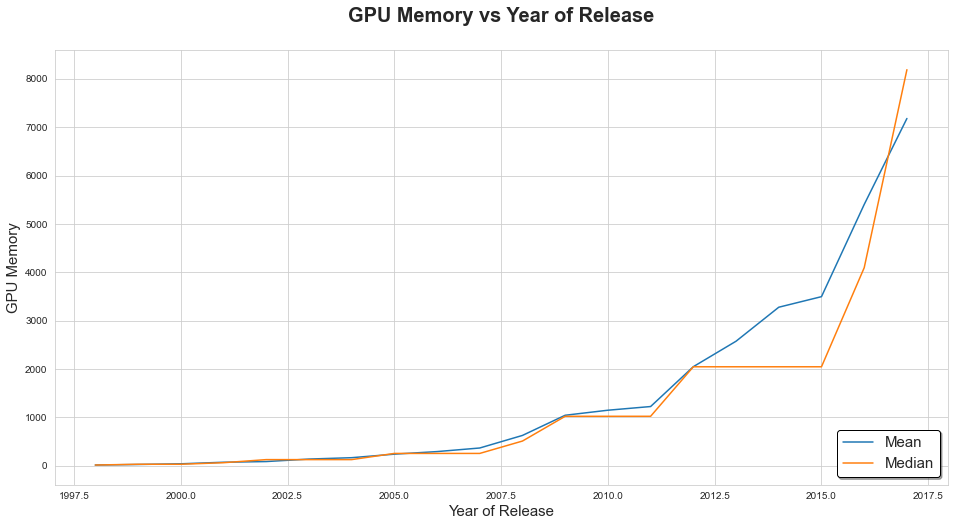

In [30]:
plt.figure()
plt.figure(figsize=(16,8))
plt.title('GPU Memory vs Year of Release', fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Year of Release', fontsize=15)
plt.ylabel('GPU Memory', fontsize=15)
sns.set_style("whitegrid")
plt.plot(year_arr, memory_arr_mean, label="Mean")
plt.plot(year_arr, memory_arr_median, label="Median")
plt.legend(loc=4, prop={'size': 15}, frameon=True,shadow=True, facecolor="white", edgecolor="black")
plt.show()

### 3.3. Creating theoretic model and fitting exponential curve
<a id="creating_theoretic_model_and_fitting_exponential_curve"></a>

<b>NOTE:</b> Let's see how above plot would look like in logarithmic scale. If Moore's law is acurate graph should be close to the straight line. As a matter of fact function that would represent memory size calculated using Moore's law taking into account the initial values would have the following form: 

$$f(x)=y_{min}2^{\frac{x-x_{min}}{2}}$$

Where: 
* $y_{min}$ - initial size of memory in MB, 
* $x_{min}$ - initial year of dataset.

In [31]:
# Short function to calculate size of memory based on Moore's law

def calculateMooresValue(x, y_trans):
    return memory_arr_median[0] * 2**((x-y_trans)/2)

# GPU Memory Size calculation based on Moore's Law

y_pred_moore_law_teoretic = calculateMooresValue(year_arr, int(year_min))

In [32]:
# Fitting exponential curve to dataset

def exponentialCurve(x, a, b, c):
    return a*2**((x-c)*b)

popt, pcov = curve_fit(exponentialCurve, \
     year_arr, memory_arr_mean,  p0=(2, 0.5, 1998))
y_pred_moore_law_fitted = exponentialCurve(year_arr, *popt)

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning:

The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning:

The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning:

The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.

c:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning:

The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



<Figure size 432x288 with 0 Axes>

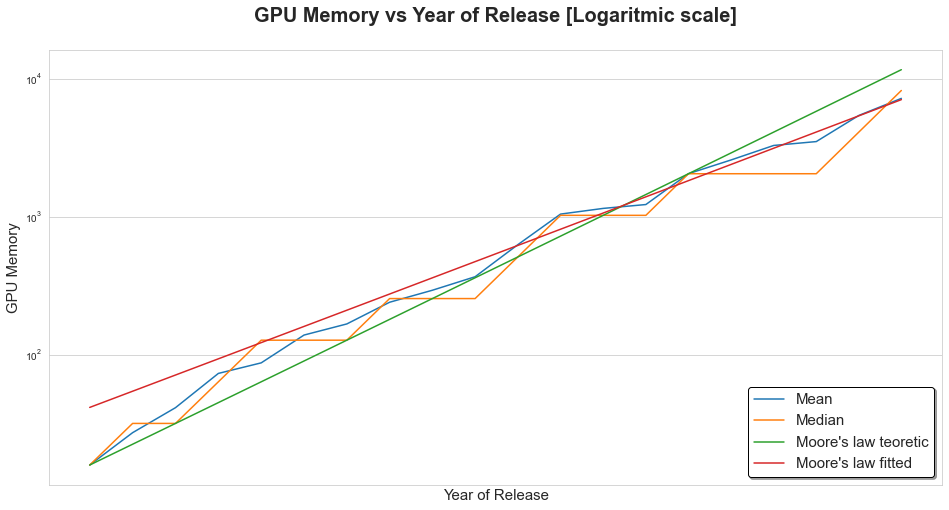

In [33]:
plt.figure()
plt.figure(figsize=(16,8))
plt.title('GPU Memory vs Year of Release [Logaritmic scale]', \
    fontsize=20, fontweight='bold', y=1.05,)
plt.xlabel('Year of Release', fontsize=15)
plt.ylabel('GPU Memory', fontsize=15)
sns.set_style("whitegrid")
plt.loglog(year_arr, memory_arr_mean, label="Mean", basex= 2)
plt.loglog(year_arr, memory_arr_median, label="Median", basex= 2)
plt.loglog(year_arr, y_pred_moore_law_teoretic, label= \
    "Moore's law teoretic", basex= 2)
plt.loglog(year_arr, y_pred_moore_law_fitted, label= \
    "Moore's law fitted", basex= 2)
plt.legend(loc=4, prop={'size': 15}, frameon=True,shadow=True, \
     facecolor="white", edgecolor="black")
plt.show()

<b>NOTE:</b> As we can see, mean size of GPUs memory tends to follow teoretic Moore's law curve [green line] but not ideally. I used curve_fit to create second curve from the same family, that will fit dataset better [red line].

### 3.4. Polynomial regression prediction model
<a id="polynomial_regression_prediction_model"></a>

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Fitting Polynomial Regression to the dataset

poly_reg_2 = PolynomialFeatures(degree = 2, include_bias=False)
poly_reg_3 = PolynomialFeatures(degree = 3, include_bias=False)

X_poly_2 = poly_reg_2.fit_transform(year_arr.reshape(-1, 1))
X_poly_3 = poly_reg_3.fit_transform(year_arr.reshape(-1, 1))

lin_reg_2 = LinearRegression()
lin_reg_3 = LinearRegression()

lin_reg_2.fit(X_poly_2, memory_arr_mean)
lin_reg_3.fit(X_poly_3, memory_arr_mean)

y_pred_lin_reg_2 = lin_reg_2.predict(poly_reg_2 \
    .fit_transform(year_arr.reshape(-1, 1)))
y_pred_lin_reg_3 = lin_reg_3.predict(poly_reg_3 \
    .fit_transform(year_arr.reshape(-1, 1)))

### 3.5. Selecting best model
<a id="selecting_best_model"></a>

In [35]:
from sklearn.metrics import r2_score

# 2nd degree curve

score = r2_score(y_pred_lin_reg_2, memory_arr_mean)
print("r2 of 2nd degree curve is equal " + str(round(score, 3)))

# 3rd degree curve

score = r2_score(y_pred_lin_reg_3, memory_arr_mean)
print("r2 of 3rd degree curve is equal " + str(round(score, 3)))

# Teoretic Moore's Law curve

score = r2_score(y_pred_moore_law_teoretic, memory_arr_mean)
print("r2 of Teoretic Moore's Law curve is equal " + str(round(score, 3)))

# Fitted Moore's Law curve

score = r2_score(y_pred_moore_law_fitted, memory_arr_mean)
print("r2 of Fitted Moore's Law curve is equal " + str(round(score, 3)))

r2 of 2nd degree curve is equal 0.947
r2 of 3rd degree curve is equal 0.985
r2 of Teoretic Moore's Law curve is equal 0.825
r2 of Fitted Moore's Law curve is equal 0.992


<b>NOTE:</b> Basing on above r2 scores I select Fitted Moore's Law curve for predicting GPUs Mean Memory Size.

In [36]:
X_grid = np.arange(min(year_arr), max(year_arr) + 5, 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))

y_pred_lin_reg_2 = lin_reg_2.predict(poly_reg_2.fit_transform(X_grid))
y_pred_lin_reg_3 = lin_reg_3.predict(poly_reg_3.fit_transform(X_grid))

X_grid = X_grid.flatten()

y_pred_moore_law_teoretic = calculateMooresValue(X_grid, int(year_min))
y_pred_moore_law_fitted = exponentialCurve(X_grid, *popt)

trace1 = go.Scatter(
    x = X_grid,
    y = y_pred_lin_reg_2,
    mode = 'lines',
    name = '2nd degree polynomial'
)
trace2 = go.Scatter(
    x = X_grid,
    y = y_pred_lin_reg_3,
    mode = 'lines',
    name = '3rd degree polynomial'
)
trace3 = go.Scatter(
    x = X_grid,
    y = y_pred_moore_law_teoretic,
    mode = 'lines',
    name = "Teoretic Moore's Law curve"
)
trace4 = go.Scatter(
    x = X_grid,
    y = y_pred_moore_law_fitted,
    mode = 'lines',
    name = "Fitted Moore's Law curve"
)

data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Fitting regression model into dataset',
    width=1000,
    height=500,
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    yaxis = dict(title= 'GPU Memory'),
    xaxis = dict(title= 'Year of Release'),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=12,
            color='#000'
        ),
        bgcolor='#E2E2E2',
        bordercolor='#FFFFFF',
        borderwidth=2
    )
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig)

### 3.6. Predicting GPUs mean memory size in 2025
<a id="predicting_gpus_mean_memory_size_in_2025"></a>

In [37]:
memory_2025 = exponentialCurve(2025, *popt)

In [39]:
print("Predicted mean size of GPU memory in 2025 is " + str(round(int(memory_2025) / 1024, 2)) + " GB.")

Predicted mean size of GPU memory in 2025 is 59.49 GB.


## 4. Bibliography
<a id="bibliography"></a>

1. Moore's law: https://en.wikipedia.org/wiki/Moore%27s_law
2. "Missingno" GitHub repository: https://github.com/ResidentMario/missingno
3. Polynomial regression theory: https://neutrium.net/mathematics/least-squares-fitting-of-a-polynomial/

# To be continued...